In [1]:
%%python --version

Python 3.10.10


# GPU

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul  2 14:17:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


# Requirements

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# cd "/content/drive/MyDrive/finrl"

In [31]:
# !git clone https://github.com/MinkyuRamen/KubigFinancialProject.git

In [32]:
# from google.colab import files
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [33]:
# %pip install -r requirements.txt --user
# %pip install SQLAlchemy==1.4.46

In [5]:
%pip install wrds
%pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
%pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-72ynccgx
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-72ynccgx
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit cfdbe462627bd6355dccee215c1aac65873c6d67
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-9ckzh60l/elegantrl_e3deb9efbc644900bab703b9a4b7e48d
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-9ckzh60l/elegantrl_e3deb9efbc644900bab703b9a4b7e48d
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 59fe4b4a1cca0a28e8a5fa4fb80eed9b5d472978
  Preparing metadata (setup.py) ... done


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

%matplotlib inline
ticker = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [9]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)


TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [10]:
prediction_5 = pd.read_csv('/content/drive/MyDrive/prediction_5.csv').set_index('Unnamed: 0')
prediction_10 = pd.read_csv('/content/drive/MyDrive/prediction_10.csv').set_index('Unnamed: 0')
prediction_30 = pd.read_csv('/content/drive/MyDrive/prediction_30.csv').set_index('Unnamed: 0')

In [11]:
# preprocess
import yfinance as yf

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ticker).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [12]:
fe = FeatureEngineer(
    use_technical_indicator = True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature=False
)
processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
processed.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.364529,7567500,XLB,0,0.0,25.521507,25.289557,100.0,66.666667,100.0,25.364529,25.364529,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,37.747677,16928400,XLE,0,0.0,25.521507,25.289557,100.0,66.666667,100.0,37.747677,37.747677,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.344017,92942347,XLF,0,0.0,25.521507,25.289557,100.0,66.666667,100.0,9.344017,9.344017,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.793039,7471500,XLI,0,0.0,25.521507,25.289557,100.0,66.666667,100.0,21.793039,21.793039,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.110197,8449400,XLK,0,0.0,25.521507,25.289557,100.0,66.666667,100.0,19.110197,19.110197,20.040001,0.0


In [14]:
list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)
processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364529,7567500.0,0.0,0.000000,25.521507,25.289557,100.000000,66.666667,100.000000,25.364529,25.364529,20.040001,0.00
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747677,16928400.0,0.0,0.000000,25.521507,25.289557,100.000000,66.666667,100.000000,37.747677,37.747677,20.040001,0.00
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.000000,25.521507,25.289557,100.000000,66.666667,100.000000,9.344017,9.344017,20.040001,0.00
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793039,7471500.0,0.0,0.000000,25.521507,25.289557,100.000000,66.666667,100.000000,21.793039,21.793039,20.040001,0.00
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110197,8449400.0,0.0,0.000000,25.521507,25.289557,100.000000,66.666667,100.000000,19.110197,19.110197,20.040001,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,147.940125,5815100.0,2.0,1.101265,151.344400,144.908068,55.182961,46.442993,6.225843,147.699630,143.517544,18.340000,4.22
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.119987,11656600.0,2.0,0.875702,77.189108,74.079747,58.998054,93.547472,22.508083,74.795711,73.269686,18.340000,4.22
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,67.526855,11857200.0,2.0,0.319781,69.807814,67.590043,50.161291,8.126302,8.132944,67.692193,66.656867,18.340000,4.22
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,132.912888,8961500.0,2.0,0.915705,134.927106,131.520086,53.906948,54.096702,6.687990,131.318106,129.596837,18.340000,4.22


In [15]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364529,7567500.0,0.0,0.0,25.521507,25.289557,100.0,66.666667,100.0,25.364529,25.364529,20.040001,0.0
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747677,16928400.0,0.0,0.0,25.521507,25.289557,100.0,66.666667,100.0,37.747677,37.747677,20.040001,0.0
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.0,25.521507,25.289557,100.0,66.666667,100.0,9.344017,9.344017,20.040001,0.0
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793039,7471500.0,0.0,0.0,25.521507,25.289557,100.0,66.666667,100.0,21.793039,21.793039,20.040001,0.0
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110197,8449400.0,0.0,0.0,25.521507,25.289557,100.0,66.666667,100.0,19.110197,19.110197,20.040001,0.0


In [18]:
prediction_5_list = []
for i in range(len(prediction_5)):
    for j in range(len(ticker)):
        prediction_5_list.append(prediction_5.iloc[i,j])

for i in range((len(processed_full)-len(prediction_5_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_5_list.append(prediction_5.iloc[-1,j])

prediction_10_list = []
for i in range(len(prediction_10)):
    for j in range(len(ticker)):
        prediction_10_list.append(prediction_10.iloc[i,j])

for i in range((len(processed_full)-len(prediction_10_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_10_list.append(prediction_10.iloc[-1,j])

prediction_30_list = []
for i in range(len(prediction_30)):
    for j in range(len(ticker)):
        prediction_30_list.append(prediction_30.iloc[i,j])
for i in range((len(processed_full)-len(prediction_30_list))//len(ticker)):
    for j in range(len(ticker)):
        prediction_30_list.append(prediction_30.iloc[-1,j])

print(len(prediction_5_list))

30204


In [19]:
processed_full['prediction_5']=prediction_5_list
processed_full['prediction_10']=prediction_10_list
processed_full['prediction_30']=prediction_30_list

processed_full

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction_5,prediction_10,prediction_30
0,2010-01-04,XLB,33.580002,34.020000,33.450001,25.364529,7567500.0,0.0,0.000000,25.521507,...,100.000000,66.666667,100.000000,25.364529,25.364529,20.040001,0.00,25.001299,25.008287,28.824316
1,2010-01-04,XLE,57.919998,58.810001,57.790001,37.747677,16928400.0,0.0,0.000000,25.521507,...,100.000000,66.666667,100.000000,37.747677,37.747677,20.040001,0.00,43.503914,40.740055,41.319206
2,2010-01-04,XLF,11.795288,11.965881,11.770918,9.344017,92942347.0,0.0,0.000000,25.521507,...,100.000000,66.666667,100.000000,9.344017,9.344017,20.040001,0.00,9.368776,8.849185,10.953069
3,2010-01-04,XLI,28.090000,28.320000,27.959999,21.793039,7471500.0,0.0,0.000000,25.521507,...,100.000000,66.666667,100.000000,21.793039,21.793039,20.040001,0.00,25.687847,26.830729,29.474950
4,2010-01-04,XLK,23.139999,23.290001,23.100000,19.110197,8449400.0,0.0,0.000000,25.521507,...,100.000000,66.666667,100.000000,19.110197,19.110197,20.040001,0.00,23.967155,25.295761,25.559303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43807,2023-05-03,XLK,149.690002,150.660004,148.179993,147.940125,5815100.0,2.0,1.101265,151.344400,...,55.182961,46.442993,6.225843,147.699630,143.517544,18.340000,4.22,159.765030,199.236300,229.869460
43808,2023-05-03,XLP,77.059998,77.379997,76.639999,76.119987,11656600.0,2.0,0.875702,77.189108,...,58.998054,93.547472,22.508083,74.795711,73.269686,18.340000,4.22,77.748860,81.883970,84.795660
43809,2023-05-03,XLU,68.639999,69.050003,67.989998,67.526855,11857200.0,2.0,0.319781,69.807814,...,50.161291,8.126302,8.132944,67.692193,66.656867,18.340000,4.22,72.211586,72.498500,82.259070
43810,2023-05-03,XLV,134.259995,134.899994,133.270004,132.912888,8961500.0,2.0,0.915705,134.927106,...,53.906948,54.096702,6.687990,131.318106,129.596837,18.340000,4.22,131.804820,142.887970,185.065430


In [34]:
processed_full.to_csv('processed_full.csv')

In [20]:
INDICATORS += ['prediction_5','prediction_10','prediction_30']

In [21]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

26613
3591


# Env

In [22]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 118


In [23]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension


env_kwargs_uni = {
    "hmax": 10000,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}
env_kwargs_multi = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}


e_train_gym = StockTradingEnv(df = train, **env_kwargs_uni) # 전체 데이터셋에 대한 것이므로 앙상블 진행시 배제

## kwargs setting

In [24]:
A2C_model_kwargs = {
                    'n_steps': 5, # batch_size = n_steps * n_env
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007,
                    # 'gae_lambda': 0.5,
                    'device':'cuda'
                    }

PPO_model_kwargs = {
                    'ent_coef': 0.0005,
                    "n_steps": 2048,
                    'learning_rate': 0.05,
                    'batch_size': 256,
                    # 'gae_lambda': 0.5,
                    'device':'cuda'
                    }

DDPG_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1_000_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64,
                      'device':'cuda'
                    }

TD3_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1_000_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64,
                      'device':'cuda'
                    }
SAC_model_kwargs = {
                      "action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 1_000_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64,
                      'device':'cuda'
                    }

timesteps_dict = {'a2c' : 100_000, # total number of samples (env steps) to train on
                 'ppo' : 100_000,
                 'ddpg' : 80_000,
                 'td3' : 100_000,
                 'sac' : 100_000
                 }

## Ornstine_Uhlenbeck_Process Estimand

In [25]:
%pip install git+https://github.com/mghadam/ouparams.git

  Cloning https://github.com/mghadam/ouparams.git to /tmp/pip-req-build-gfs3z4ya
  Running command git clone --filter=blob:none --quiet https://github.com/mghadam/ouparams.git /tmp/pip-req-build-gfs3z4ya
  Resolved https://github.com/mghadam/ouparams.git to commit 0862e77b606d833d1955fc47c689661ad12a446d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ouparams: filename=ouparams-0.0.1-py3-none-any.whl size=3344 sha256=e8e112fd8bed02c01557828de76fe22482d03c8eb7b0bd73f7e72404738efe79
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5wc8ii4/wheels/2a/c9/1d/3d8c7df0a1aa47fcc8488bd8b3625871c16dbea6ff684a2e78
Successfully built ouparams


In [26]:
# preprocess to numpy array

train_close = train.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
train_close
XLB= train_close[train_close['tic']=='XLB']['close'].values
XLE= train_close[train_close['tic']=='XLE']['close'].values
XLF= train_close[train_close['tic']=='XLF']['close'].values
XLI= train_close[train_close['tic']=='XLI']['close'].values
XLK= train_close[train_close['tic']=='XLK']['close'].values
XLP= train_close[train_close['tic']=='XLP']['close'].values
XLU= train_close[train_close['tic']=='XLU']['close'].values
XLV= train_close[train_close['tic']=='XLV']['close'].values
XLY= train_close[train_close['tic']=='XLY']['close'].values

In [27]:
from ouparams import ouparams
sigma_XLB, theta_XLB = ouparams.find(XLB)[1:]
sigma_XLE, theta_XLE = ouparams.find(XLE)[1:]
sigma_XLF, theta_XLF = ouparams.find(XLF)[1:]
sigma_XLI, theta_XLI = ouparams.find(XLF)[1:]
sigma_XLK, theta_XLK = ouparams.find(XLK)[1:]
sigma_XLP, theta_XLP = ouparams.find(XLP)[1:]
sigma_XLU, theta_XLU = ouparams.find(XLU)[1:]
sigma_XLV, theta_XLV = ouparams.find(XLV)[1:]
sigma_XLY, theta_XLY = ouparams.find(XLY)[1:]

print(sigma_XLB, theta_XLB)

0.5638992381523543 0.00010636985593799326


In [28]:
sigma_ = [sigma_XLB, sigma_XLE, sigma_XLF, sigma_XLI ,sigma_XLK, sigma_XLP ,sigma_XLU ,sigma_XLV, sigma_XLY]
theta_ = [theta_XLB, theta_XLE, theta_XLF, theta_XLI ,theta_XLK, theta_XLP ,theta_XLU ,theta_XLV, theta_XLY]

# Agent

In [29]:
# DRL models from Stable Baselines 3
from __future__ import annotations

import time

import numpy as np
import pandas as pd
from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3 import TD3
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv

from finrl import config
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split

MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {x: config.__dict__[f"{x.upper()}_PARAMS"] for x in MODELS.keys()}

NOISE = {
    "normal": NormalActionNoise,
    "ornstein_uhlenbeck": OrnsteinUhlenbeckActionNoise,
}


class TensorboardCallback(BaseCallback):
    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        try:
            self.logger.record(key="train/reward", value=self.locals["rewards"][0])
        except BaseException:
            self.logger.record(key="train/reward", value=self.locals["reward"][0])
        return True


class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        get_model()
            setup DRL algorithms
        train_model()
            train DRL algorithms in a train dataset
            and output the trained model
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
        seed=None,
        tensorboard_log=None,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma= sigma_ * np.ones(n_actions), theta=theta_ * np.ones(n_actions)
            )
        print(model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=tensorboard_log,
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **model_kwargs,
        )

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        return model

    @staticmethod
    def DRL_prediction(model, environment, deterministic=True):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        #         state_memory=[] #add memory pool to store states
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
                account_memory = test_env.env_method(method_name="save_asset_memory")
                actions_memory = test_env.env_method(method_name="save_action_memory")
            #                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    @staticmethod
    def DRL_prediction_load_from_file(model_name, environment, cwd, deterministic=True):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")
        try:
            # load agent
            model = MODELS[model_name].load(cwd)
            print("Successfully load model", cwd)
        except BaseException:
            raise ValueError("Fail to load agent!")

        # test on the testing env
        state = environment.reset()
        episode_returns = []  # the cumulative_return / initial_account
        episode_total_assets = [environment.initial_total_asset]
        done = False
        while not done:
            action = model.predict(state, deterministic=deterministic)[0]
            state, reward, done, _ = environment.step(action)

            total_asset = (
                environment.amount
                + (environment.price_ary[environment.day] * environment.stocks).sum()
            )
            episode_total_assets.append(total_asset)
            episode_return = total_asset / environment.initial_total_asset
            episode_returns.append(episode_return)

        print("episode_return", episode_return)
        print("Test Finished!")
        return episode_total_assets


class DRLEnsembleAgent:
    @staticmethod
    def get_model(
        model_name,
        env,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        seed=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            temp_model_kwargs = MODEL_KWARGS[model_name]
        else:
            temp_model_kwargs = model_kwargs.copy()

        if "action_noise" in temp_model_kwargs:
            n_actions = env.action_space.shape[-1]
            temp_model_kwargs["action_noise"] = NOISE[
                temp_model_kwargs["action_noise"]
            ](mean=np.zeros(n_actions), sigma=sigma_ * np.ones(n_actions), theta=theta_ * np.ones(n_actions))
        print(temp_model_kwargs)
        return MODELS[model_name](
            policy=policy,
            env=env,
            tensorboard_log=f"{config.TENSORBOARD_LOG_DIR}/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            seed=seed,
            **temp_model_kwargs,
        )

    @staticmethod
    def train_model(model, model_name, tb_log_name, iter_num, total_timesteps=5000):
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=TensorboardCallback(),
        )
        model.save(
            f"{config.TRAINED_MODEL_DIR}/{model_name.upper()}_{total_timesteps // 1000}k_{iter_num}"
        )
        return model

    @staticmethod
    def get_validation_sharpe(iteration, model_name):
        """Calculate Sharpe ratio based on validation results"""
        df_total_value = pd.read_csv(
            f"results/account_value_validation_{model_name}_{iteration}.csv"
        )
        # If the agent did not make any transaction
        if df_total_value["daily_return"].var() == 0:
            if df_total_value["daily_return"].mean() > 0:
                return np.inf
            else:
                return 0.0
        else:
            return (
                (4**0.5)
                * df_total_value["daily_return"].mean()
                / df_total_value["daily_return"].std()
            )

    def __init__(
        self,
        df,
        train_period,
        val_test_period,
        rebalance_window,
        validation_window,
        stock_dim,
        hmax,
        initial_amount,
        buy_cost_pct,
        sell_cost_pct,
        reward_scaling,
        state_space,
        action_space,
        tech_indicator_list,
        print_verbosity,
    ):
        self.df = df
        self.train_period = train_period
        self.val_test_period = val_test_period

        self.unique_trade_date = df[
            (df.date > val_test_period[0]) & (df.date <= val_test_period[1])
        ].date.unique()
        self.rebalance_window = rebalance_window
        self.validation_window = validation_window

        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.buy_cost_pct = buy_cost_pct
        self.sell_cost_pct = sell_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.print_verbosity = print_verbosity

    def DRL_validation(self, model, test_data, test_env, test_obs):
        """validation process"""
        for _ in range(len(test_data.index.unique())):
            action, _states = model.predict(test_obs)
            test_obs, rewards, dones, info = test_env.step(action)

    def DRL_prediction(
        self, model, name, last_state, iter_num, turbulence_threshold, initial
    ):
        """make a prediction based on trained model"""

        ## trading env
        trade_data = data_split(
            self.df,
            start=self.unique_trade_date[iter_num - self.rebalance_window],
            end=self.unique_trade_date[iter_num],
        )
        trade_env = DummyVecEnv(
            [
                lambda: StockTradingEnv(
                    df=trade_data,
                    stock_dim=self.stock_dim,
                    hmax=self.hmax,
                    initial_amount=self.initial_amount,
                    num_stock_shares=[0] * self.stock_dim,
                    buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                    sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                    reward_scaling=self.reward_scaling,
                    state_space=self.state_space,
                    action_space=self.action_space,
                    tech_indicator_list=self.tech_indicator_list,
                    turbulence_threshold=turbulence_threshold,
                    initial=initial,
                    previous_state=last_state,
                    model_name=name,
                    mode="trade",
                    iteration=iter_num,
                    print_verbosity=self.print_verbosity,
                )
            ]
        )

        trade_obs = trade_env.reset()

        for i in range(len(trade_data.index.unique())):
            action, _states = model.predict(trade_obs)
            trade_obs, rewards, dones, info = trade_env.step(action)
            if i == (len(trade_data.index.unique()) - 2):
                # print(env_test.render())
                last_state = trade_env.envs[0].render()

        df_last_state = pd.DataFrame({"last_state": last_state})
        # 수정(06/28): run_ensemble_strategy 실행시 ValueError: If using all scalar values, you must pass an index 오류 출력됨.
        # 수정: df_last_state가 run_ensemble_strategy를 시행하는데 있어서 쓰이지 않음. 따라서 제거해주고 시행해봄. 그 결과 동일한 오류 발생
        df_last_state.to_csv(f"results/last_state_{name}_{i}.csv", index=False)
        # 수정 : 다시 풀어줌. requirements.txt issue인게 밝혀짐.
        # 수정 : last_state = trade_env.render() --> trade_env.evns[0].render() 로 바꿔줌
        return last_state

    def run_ensemble_strategy_(
        self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, TD3_model_kwargs, SAC_model_kwargs, timesteps_dict
    ):
        """Ensemble Strategy that combines PPO, A2C and DDPG"""
        print("============Start Ensemble Strategy============")
        # for ensemble model, it's necessary to feed the last state
        # of the previous model to the current model as the initial state
        last_state_ensemble = []

        ppo_sharpe_list = []
        ddpg_sharpe_list = []
        a2c_sharpe_list = []
        td3_sharpe_list = []
        sac_sharpe_list = []

        model_use = []
        validation_start_date_list = []
        validation_end_date_list = []
        iteration_list = []

        insample_turbulence = self.df[
            (self.df.date < self.train_period[1])
            & (self.df.date >= self.train_period[0])
        ]
        insample_turbulence_threshold = np.quantile(
            insample_turbulence.turbulence.values, 0.90
        )

        start = time.time()
        for i in range(
            self.rebalance_window + self.validation_window,
            len(self.unique_trade_date),
            self.rebalance_window,
        ):
            validation_start_date = self.unique_trade_date[
                i - self.rebalance_window - self.validation_window
            ]
            validation_end_date = self.unique_trade_date[i - self.rebalance_window]

            validation_start_date_list.append(validation_start_date)
            validation_end_date_list.append(validation_end_date)
            iteration_list.append(i)

            print("============================================")
            ## initial state is empty
            if i - self.rebalance_window - self.validation_window == 0:
                # inital state
                initial = True
            else:
                # previous state
                initial = False

            # Tuning trubulence index based on historical data
            # Turbulence lookback window is one quarter (63 days)
            end_date_index = self.df.index[
                self.df["date"]
                == self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ]
            ].to_list()[-1]
            start_date_index = end_date_index - 63 + 1

            historical_turbulence = self.df.iloc[
                start_date_index : (end_date_index + 1), :
            ]

            historical_turbulence = historical_turbulence.drop_duplicates(
                subset=["date"]
            )

            historical_turbulence_mean = np.mean(
                historical_turbulence.turbulence.values
            )

            # print(historical_turbulence_mean)

            if historical_turbulence_mean > insample_turbulence_threshold:
                # if the mean of the historical data is greater than the 90% quantile of insample turbulence data
                # then we assume that the current market is volatile,
                # therefore we set the 90% quantile of insample turbulence data as the turbulence threshold
                # meaning the current turbulence can't exceed the 90% quantile of insample turbulence data
                turbulence_threshold = insample_turbulence_threshold
            else:
                # if the mean of the historical data is less than the 90% quantile of insample turbulence data
                # then we tune up the turbulence_threshold, meaning we lower the risk
                turbulence_threshold = np.quantile(
                    insample_turbulence.turbulence.values, 1
                )

            turbulence_threshold = np.quantile(
                insample_turbulence.turbulence.values, 0.90
            )
            print("turbulence_threshold: ", turbulence_threshold)

            ############## Environment Setup starts ##############
            ## training env
            train = data_split(
                self.df,
                start=self.train_period[0],
                end=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            self.train_env = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=train,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )

            validation = data_split(
                self.df,
                start=self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
                end=self.unique_trade_date[i - self.rebalance_window],
            )
            ############## Environment Setup ends ##############

            ############## Training and Validation starts ##############
            print(
                "======Model training from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[
                    i - self.rebalance_window - self.validation_window
                ],
            )
            # print("training: ",len(data_split(df, start=20090000, end=test.datadate.unique()[i-rebalance_window]) ))
            # print("==============Model Training===========")
            print("======A2C Training========")
            model_a2c = self.get_model(
                "a2c", self.train_env, policy="MlpPolicy", model_kwargs=A2C_model_kwargs
            )
            model_a2c = self.train_model(
                model_a2c,
                "a2c",
                tb_log_name=f"a2c_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["a2c"],
            )  # 100_000

            print(
                "======A2C Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_a2c = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="A2C",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_a2c = val_env_a2c.reset()
            self.DRL_validation(
                model=model_a2c,
                test_data=validation,
                test_env=val_env_a2c,
                test_obs=val_obs_a2c,
            )
            sharpe_a2c = self.get_validation_sharpe(i, model_name="A2C")
            print("A2C Sharpe Ratio: ", sharpe_a2c)

            print("======PPO Training========")
            model_ppo = self.get_model(
                "ppo", self.train_env, policy="MlpPolicy", model_kwargs=PPO_model_kwargs
            )
            model_ppo = self.train_model(
                model_ppo,
                "ppo",
                tb_log_name=f"ppo_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ppo"],
            )  # 100_000
            print(
                "======PPO Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ppo = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="PPO",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ppo = val_env_ppo.reset()
            self.DRL_validation(
                model=model_ppo,
                test_data=validation,
                test_env=val_env_ppo,
                test_obs=val_obs_ppo,
            )
            sharpe_ppo = self.get_validation_sharpe(i, model_name="PPO")
            print("PPO Sharpe Ratio: ", sharpe_ppo)

            print("======DDPG Training========")
            model_ddpg = self.get_model(
                "ddpg",
                self.train_env,
                policy="MlpPolicy",
                model_kwargs=DDPG_model_kwargs,
            )
            model_ddpg = self.train_model(
                model_ddpg,
                "ddpg",
                tb_log_name=f"ddpg_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["ddpg"],
            )  # 80_000
            print(
                "======DDPG Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_ddpg = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="DDPG",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_ddpg = val_env_ddpg.reset()
            self.DRL_validation(
                model=model_ddpg,
                test_data=validation,
                test_env=val_env_ddpg,
                test_obs=val_obs_ddpg,
            )
            sharpe_ddpg = self.get_validation_sharpe(i, model_name="DDPG")

            print("======SAC Training========")
            model_sac = self.get_model(
                "sac", self.train_env, policy="MlpPolicy", model_kwargs=SAC_model_kwargs
            )
            model_sac = self.train_model(
                model_sac,
                "sac",
                tb_log_name=f"sac_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["sac"],
                # 100_000
            )

            print(
                "======SAC Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_sac = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="SAC",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_sac = val_env_sac.reset()
            self.DRL_validation(
                model=model_sac,
                test_data=validation,
                test_env=val_env_sac,
                test_obs=val_obs_sac,
            )
            sharpe_sac = self.get_validation_sharpe(i, model_name="SAC")
            print("SAC Sharpe Ratio : ", sharpe_sac)

            print("======TD3 Training========")
            model_td3 = self.get_model(
                "td3", self.train_env, policy="MlpPolicy", model_kwargs=TD3_model_kwargs
            )
            model_td3 = self.train_model(
                model_td3,
                "td3",
                tb_log_name=f"td3_{i}",
                iter_num=i,
                total_timesteps=timesteps_dict["td3"],
                # 100_000
            )

            print(
                "======TD3 Validation from: ",
                validation_start_date,
                "to ",
                validation_end_date,
            )
            val_env_td3 = DummyVecEnv(
                [
                    lambda: StockTradingEnv(
                        df=validation,
                        stock_dim=self.stock_dim,
                        hmax=self.hmax,
                        initial_amount=self.initial_amount,
                        num_stock_shares=[0] * self.stock_dim,
                        buy_cost_pct=[self.buy_cost_pct] * self.stock_dim,
                        sell_cost_pct=[self.sell_cost_pct] * self.stock_dim,
                        reward_scaling=self.reward_scaling,
                        state_space=self.state_space,
                        action_space=self.action_space,
                        tech_indicator_list=self.tech_indicator_list,
                        turbulence_threshold=turbulence_threshold,
                        iteration=i,
                        model_name="TD3",
                        mode="validation",
                        print_verbosity=self.print_verbosity,
                    )
                ]
            )
            val_obs_td3 = val_env_td3.reset()
            self.DRL_validation(
                model=model_td3,
                test_data=validation,
                test_env=val_env_td3,
                test_obs=val_obs_td3,
            )
            sharpe_td3 = self.get_validation_sharpe(i, model_name="TD3")
            print("TD3 Sharpe Ratio : ", sharpe_td3)

            ppo_sharpe_list.append(sharpe_ppo)
            a2c_sharpe_list.append(sharpe_a2c)
            ddpg_sharpe_list.append(sharpe_ddpg)
            sac_sharpe_list.append(sharpe_sac)
            td3_sharpe_list.append(sharpe_td3)

            print(
                "======Best Model Retraining from: ",
                self.train_period[0],
                "to ",
                self.unique_trade_date[i - self.rebalance_window],
            )
            # Environment setup for model retraining up to first trade date
            # train_full = data_split(self.df, start=self.train_period[0], end=self.unique_trade_date[i - self.rebalance_window])
            # self.train_full_env = DummyVecEnv([lambda: StockTradingEnv(train_full,
            #                                                    self.stock_dim,
            #                                                    self.hmax,
            #                                                    self.initial_amount,
            #                                                    self.buy_cost_pct,
            #                                                    self.sell_cost_pct,
            #                                                    self.reward_scaling,
            #                                                    self.state_space,
            #                                                    self.action_space,
            #                                                    self.tech_indicator_list,
            #                                                    print_verbosity=self.print_verbosity)])
            # Model Selection based on sharpe ratio
            if (sharpe_ppo >= sharpe_a2c) & (sharpe_ppo >= sharpe_ddpg) & (sharpe_ppo >= sharpe_sac) & (sharpe_ppo >= sharpe_td3):
                model_use.append("PPO")
                model_ensemble = model_ppo

                # model_ensemble = self.get_model("ppo",self.train_full_env,policy="MlpPolicy",model_kwargs=PPO_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ppo']) #100_000
            elif (sharpe_a2c >= sharpe_ppo) & (sharpe_a2c >= sharpe_ddpg) & (sharpe_a2c >= sharpe_sac) & (sharpe_a2c >= sharpe_td3):
                model_use.append("A2C")
                model_ensemble = model_a2c

                # model_ensemble = self.get_model("a2c",self.train_full_env,policy="MlpPolicy",model_kwargs=A2C_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['a2c']) #100_000
            elif (sharpe_ddpg >= sharpe_ppo) & (sharpe_ddpg >= sharpe_a2c) & (sharpe_ddpg >= sharpe_sac) & (sharpe_ddpg >= sharpe_td3):
                model_use.append("DDPG")
                model_ensemble = model_ddpg

                # model_ensemble = self.get_model("ddpg",self.train_full_env,policy="MlpPolicy",model_kwargs=DDPG_model_kwargs)
                # model_ensemble = self.train_model(model_ensemble, "ensemble", tb_log_name="ensemble_{}".format(i), iter_num = i, total_timesteps=timesteps_dict['ddpg']) #50_000#

            elif (sharpe_sac >= sharpe_ppo) & (sharpe_sac >= sharpe_a2c) & (sharpe_sac >= sharpe_ddpg) & (sharpe_sac >= sharpe_td3):
                model_use.append("SAC")
                model_ensemble = model_sac

            else:
                model_use.append("TD3")
                model_ensemble = model_td3
            ############## Training and Validation ends ##############

            ############## Trading starts ##############
            print(
                "======Trading from: ",
                self.unique_trade_date[i - self.rebalance_window],
                "to ",
                self.unique_trade_date[i],
            )
            # print("Used Model: ", model_ensemble)
            last_state_ensemble = self.DRL_prediction(
                model=model_ensemble,
                name="ensemble",
                last_state=last_state_ensemble,
                iter_num=i,
                turbulence_threshold=turbulence_threshold,
                initial=initial,
            )
            ############## Trading ends #############

        end = time.time()
        print("Ensemble Strategy took: ", (end - start) / 60, " minutes")

        df_summary = pd.DataFrame(
            [
                iteration_list,
                validation_start_date_list,
                validation_end_date_list,
                model_use,
                a2c_sharpe_list,
                ppo_sharpe_list,
                ddpg_sharpe_list,
                sac_sharpe_list,
                td3_sharpe_list
            ]
        ).T
        df_summary.columns = [
            "Iter",
            "Val Start",
            "Val End",
            "Model Used",
            "A2C Sharpe",
            "PPO Sharpe",
            "DDPG Sharpe",
            "SAC Sharpe",
            "TD3 Sharpe"
        ]

        return df_summary

In [30]:
DRLEnsembleAgent.run_ensemble_strategy_

<function __main__.DRLEnsembleAgent.run_ensemble_strategy_(self, A2C_model_kwargs, PPO_model_kwargs, DDPG_model_kwargs, TD3_model_kwargs, SAC_model_kwargs, timesteps_dict)>

In [31]:
rebalance_window = 63 # number of days to retrain the model
validation_window = 63 # number of days to do validation

ensemble_agent = DRLEnsembleAgent(df=processed_full,
                                train_period = (TRAIN_START_DATE, TRAIN_END_DATE),
                                val_test_period = (TRADE_START_DATE, TRADE_END_DATE),
                                rebalance_window=rebalance_window,
                                validation_window=validation_window,
                                **env_kwargs_multi )

In [32]:
df_summary = ensemble_agent.run_ensemble_strategy_(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 SAC_model_kwargs,
                                                 TD3_model_kwargs,
                                                 timesteps_dict)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
|    time_elapsed    | 573        |
|    total_timesteps | 37764      |
| train/             |            |
|    actor_loss      | 1.94e+11   |
|    critic_loss     | 2.35e+19   |
|    ent_coef        | 1.47e+08   |
|    ent_coef_loss   | -2.43e+03  |
|    learning_rate   | 0.0005     |
|    n_updates       | 37663      |
|    reward          | -1.8708254 |
-----------------------------------
day: 3146, episode: 105
begin_total_asset: 1000000.00
end_total_asset: 3721326.98
total_reward: 2721326.98
total_cost: 2908.99
total_trades: 23749
Sharpe: 0.747
-----------------------------------
| time/              |            |
|    episodes        | 16         |
|    fps             | 66         |
|    time_elapsed    | 762        |
|    total_timesteps | 50352      |
| train/             |            |
|    actor_loss      | 1.18e+13   |
|    critic_loss     | 1.18e+26   |
|    ent_coef        | 7.92e+10   |
|    ent_coef_loss   | -3.25e+03  |
|    learni

In [33]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-10-04,2022-01-03,PPO,0.326257,0.583925,0.222091,0.37878,0.319924
1,189,2022-01-03,2022-04-04,SAC,-0.320031,-0.320185,-0.089441,-0.017085,-0.250471
2,252,2022-04-04,2022-07-06,A2C,-0.52318,-0.593024,-0.523324,-0.534957,-0.526993
3,315,2022-07-06,2022-10-04,A2C,0.027793,0.021532,-0.136567,-0.058768,0.014166
4,378,2022-10-04,2023-01-04,SAC,-0.108112,-0.100759,-0.155534,-0.083647,-0.13775


## Checking for option

In [36]:
val_test_period_ = (TRADE_START_DATE, TRADE_END_DATE)
dat = processed_full
unique_trade_date_ = dat[(dat.date > val_test_period_[0]) & (dat.date <= val_test_period_[1])].date.unique()
print(unique_trade_date_[0],unique_trade_date_[-1])

2021-10-04 2023-05-03


In [37]:
validation_start_date_list_ = []
validation_end_date_list_ = []
iteration_list_ = []


import time
start = time.time()
for i in range(rebalance_window + validation_window,len(unique_trade_date_),rebalance_window,):
    validation_start_date = unique_trade_date_[i - rebalance_window - validation_window]
    validation_end_date = unique_trade_date_[i - rebalance_window]

    validation_start_date_list_.append(validation_start_date)
    validation_end_date_list_.append(validation_end_date)
    iteration_list_.append(i) # 126, 189, 252, 315, 378, 441, 504, 567

In [39]:
validation_start_date_list_


['2021-10-04', '2022-01-03', '2022-04-04', '2022-07-06', '2022-10-04']

In [40]:
validation_end_date_list_

['2022-01-03', '2022-04-04', '2022-07-06', '2022-10-04', '2023-01-04']

In [41]:
iteration_list_

[126, 189, 252, 315, 378]

In [43]:
list(range(rebalance_window + validation_window,len(unique_trade_date_),rebalance_window))

[126, 189, 252, 315, 378]

In [44]:
len(unique_trade_date_)

398

In [74]:
datetime.datetime(2023,1,4) + datetime.timedelta(days=validation_window)

datetime.datetime(2023, 3, 8, 0, 0)

## BackTest

In [50]:
unique_trade_date = processed_full[(processed_full.date > TRADE_START_DATE)&(processed_full.date <= TRADE_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('/content/results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    # df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.6247156208614475


In [51]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2022-01-03,NaN,2022-01-03
1,999578.119419,2022-01-04,-0.000422,2022-01-04
2,999540.799651,2022-01-05,-0.000037,2022-01-05
3,999464.253343,2022-01-06,-0.000077,2022-01-06
4,999377.244789,2022-01-07,-0.000087,2022-01-07


<Axes: >

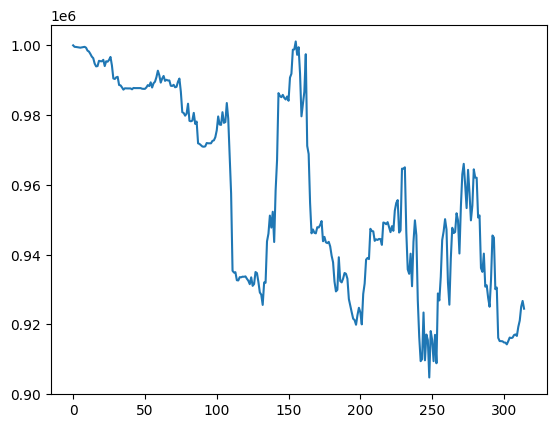

In [52]:
%matplotlib inline
df_account_value.account_value.plot()

In [53]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.060900
Cumulative returns    -0.075536
Annual volatility      0.093849
Sharpe ratio          -0.624716
Calmar ratio          -0.632560
Stability              0.611913
Max drawdown          -0.096275
Omega ratio            0.874434
Sortino ratio         -0.843192
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.903092
Daily value at risk   -0.012057
dtype: float64


In [61]:
#baseline stats
print("==============Get Baseline Stats===========")
df_ndx_ = get_baseline(
        ticker="^NDX",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_ndx_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
Annual return         -0.166662
Cumulative returns    -0.203216
Annual volatility      0.308976
Sharpe ratio          -0.437664
Calmar ratio          -0.472349
Stability              0.480914
Max drawdown          -0.352837
Omega ratio            0.933247
Sortino ratio         -0.609704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.018180
Daily value at risk   -0.039464
dtype: float64


In [65]:
df_ndx = pd.DataFrame()
df_ndx['date'] = df_account_value['date']
df_ndx['ndx'] = df_ndx_['close'] / df_ndx_['close'][0] * env_kwargs_multi["initial_amount"]
df_ndx.to_csv("df_ndx.csv")

df_ndx = df_ndx.set_index(df_ndx.columns[0])
df_ndx.to_csv("df_ndx+.csv")

df_account_value.to_csv("df_account_value.csv")

print("df_ndx:",df_ndx)

df_ndx:                        ndx
date                      
2022-01-03  1000000.000000
2022-01-04   986544.530144
2022-01-05   955762.970969
2022-01-06   955373.926518
2022-01-07   944879.905162
...                    ...
2023-03-29   778463.803479
2023-03-30   785560.580269
2023-03-31   798784.008249
2023-04-03   796784.222715
2023-04-04             NaN

[315 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date :         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
393  2023-04-27
394  2023-04-28
395  2023-05-01
396  2023-05-02
397  2023-05-03

[398 rows x 1 columns]
df_result_ensemble:                   ensemble
date                      
2022-01-03  1000000.000000
2022-01-04   999578.119419
2022-01-05   999540.799651
2022-01-06   999464.253343
2022-01-07   999377.244789
...                    ...
2023-03-29   919255.930847
2023-03-30   921052.085838
2023-03-31   925008.537752
2023-04-03   926689.175840
2023-04-04   924464.126983

[315 rows x 1 columns]
==============Compare to ndx===========


<Figure size 1500x500 with 0 Axes>

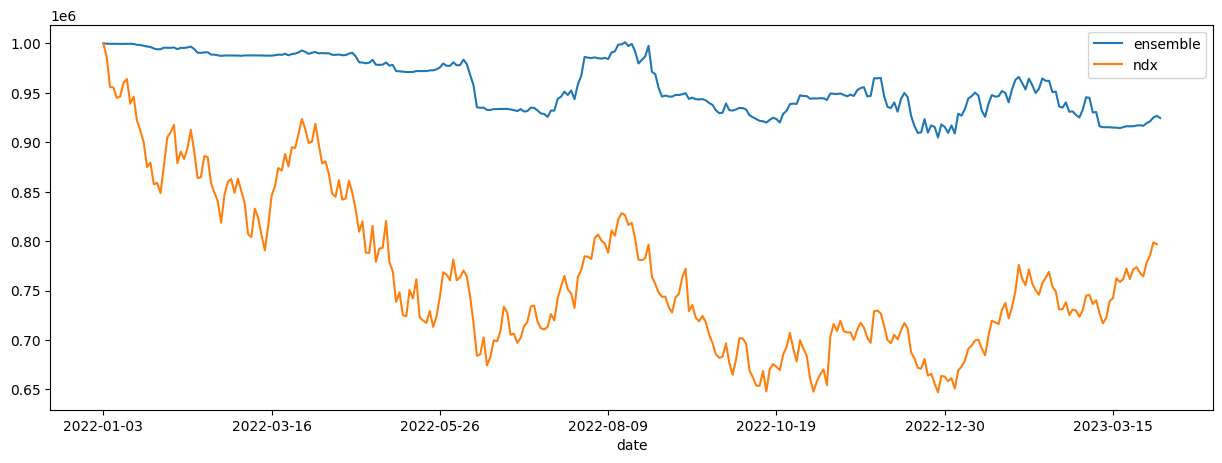

In [67]:
# plot
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date' : df_account_value['date'], 'ensemble' : df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')
print("df_result_ensemble.columns: ", df_result_ensemble.columns)

print("df_trade_date : ", df_trade_date)

df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble:", df_result_ensemble)

print("==============Compare to ndx===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_ndx, left_index=True, right_index=True)
result.to_csv("result.csv")
result.columns = ['ensemble', 'ndx']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

In [79]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (314, 8)
Annual return         -0.066002
Cumulative returns    -0.081561
Annual volatility      0.188609
Sharpe ratio          -0.269023
Calmar ratio          -0.300816
Stability              0.080948
Max drawdown          -0.219408
Omega ratio            0.956841
Sortino ratio         -0.373593
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.988482
Daily value at risk   -0.023964
dtype: float64


In [81]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs_multi["initial_amount"]
df_dji.to_csv("df_dji.csv")

df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv("df_account_value.csv")

print("df_dji:",df_dji)

df_dji:                      dji
date                    
2022-01-03  1.000000e+06
2022-01-04  1.005866e+06
2022-01-05  9.951360e+05
2022-01-06  9.904718e+05
2022-01-07  9.903404e+05
...                  ...
2023-03-29  8.942886e+05
2023-03-30  8.981544e+05
2023-03-31  9.095010e+05
2023-04-03  9.184391e+05
2023-04-04           NaN

[315 rows x 1 columns]


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date :         datadate
0    2021-10-04
1    2021-10-05
2    2021-10-06
3    2021-10-07
4    2021-10-08
..          ...
393  2023-04-27
394  2023-04-28
395  2023-05-01
396  2023-05-02
397  2023-05-03

[398 rows x 1 columns]
df_result_ensemble:                   ensemble
date                      
2022-01-03  1000000.000000
2022-01-04   999578.119419
2022-01-05   999540.799651
2022-01-06   999464.253343
2022-01-07   999377.244789
...                    ...
2023-03-29   919255.930847
2023-03-30   921052.085838
2023-03-31   925008.537752
2023-04-03   926689.175840
2023-04-04   924464.126983

[315 rows x 1 columns]
==============Compare to DJIA===========


<Figure size 1500x500 with 0 Axes>

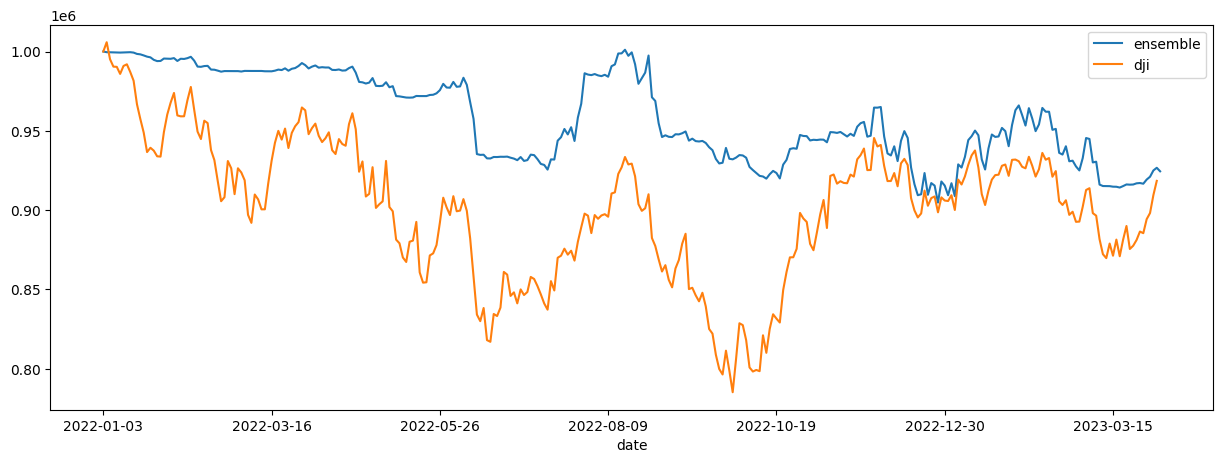

In [82]:
# plot
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date' : df_account_value['date'], 'ensemble' : df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')
print("df_result_ensemble.columns: ", df_result_ensemble.columns)

print("df_trade_date : ", df_trade_date)

df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble:", df_result_ensemble)

print("==============Compare to DJIA===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

### Download and save the result

In [75]:
!pwd # 현재 directory

/content


In [78]:
!zip -r /content/Tous_Ensemble_results.zip /content/results/
!zip -r /content/Tous_Ensemble_tensorboard_log.zip /content/tensorboard_log/
!zip -r /content/Tous_Ensemble_trained_models.zip /content/trained_models/


  adding: content/results/ (stored 0%)
  adding: content/results/account_rewards_validation_PPO_378.csv (deflated 56%)
  adding: content/results/account_rewards_validation_DDPG_126.csv (deflated 57%)
  adding: content/results/account_value_validation_SAC_126.png (deflated 9%)
  adding: content/results/actions_validation_SAC_189.csv (deflated 87%)
  adding: content/results/account_value_trade_ensemble_315.png (deflated 10%)
  adding: content/results/account_rewards_validation_TD3_315.csv (deflated 57%)
  adding: content/results/account_rewards_validation_PPO_189.csv (deflated 58%)
  adding: content/results/actions_validation_TD3_315.csv (deflated 88%)
  adding: content/results/actions_trade_ensemble_315.csv (deflated 77%)
  adding: content/results/account_value_validation_A2C_378.png (deflated 8%)
  adding: content/results/account_value_validation_TD3_126.png (deflated 9%)
  adding: content/results/account_rewards_validation_SAC_189.csv (deflated 58%)
  adding: content/results/actions_v

Downloaded and saved to Harddisk

# Agent_2 : On_Policy (A2C, PPO)

pros : fast convergence, stable learning

Due to name issues, run it on another jupyter notebook


# Agent_3 : Off_Policy (DDPG, SAC, TD3)

pros : sample efficiency, more exploration

Due to name issues, run it on another jupyter notebook
